In [1]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import logging
import multiprocessing

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import scipy.stats as stats

import numpyro
import numpyro.distributions as dist

from hbmep.model import Baseline
from hbmep_paper.utils.constants import HBM
from hbmep.config import Config
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)


In [2]:
class Simulation(Baseline):
    LINK = HBM

    def __init__(self, config: Config, mu_a_delta: int, sigma_a_delta: int):
        super(Simulation, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]
        self.mu_a_delta = mu_a_delta
        self.sigma_a_delta = sigma_a_delta

    def _model(self, subject, features, intensity, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_data = intensity.shape[0]
        n_subject = np.unique(subject).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        n_baseline = 1
        n_delta = 1

        global_sigma_b_baseline = numpyro.sample("global_sigma_b_baseline", dist.HalfNormal(100))
        global_sigma_v_baseline = numpyro.sample("global_sigma_v_baseline", dist.HalfNormal(100))

        global_sigma_L_baseline = numpyro.sample("global_sigma_L_baseline", dist.HalfNormal(50))
        global_sigma_H_baseline = numpyro.sample("global_sigma_H_baseline", dist.HalfNormal(500))

        global_sigma_g_1_baseline = numpyro.sample("global_sigma_g_1_baseline", dist.HalfNormal(100))
        global_sigma_g_2_baseline = numpyro.sample("global_sigma_g_2_baseline", dist.HalfNormal(100))

        """ Baseline """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_baseline", n_baseline, dim=-2):
                """ Hyper-priors """
                mu_a_baseline = numpyro.sample(
                    "mu_a_baseline",
                    dist.TruncatedNormal(50, 50, low=0)
                )
                sigma_a_baseline = numpyro.sample(
                    "sigma_a_baseline",
                    dist.HalfNormal(50)
                )

                sigma_b_baseline = numpyro.sample("sigma_b_baseline", dist.HalfNormal(global_sigma_b_baseline))
                sigma_v_baseline = numpyro.sample("sigma_v_baseline", dist.HalfNormal(global_sigma_v_baseline))

                sigma_L_baseline = numpyro.sample("sigma_L_baseline", dist.HalfNormal(global_sigma_L_baseline))
                sigma_H_baseline = numpyro.sample("sigma_H_baseline", dist.HalfNormal(global_sigma_H_baseline))

                sigma_g_1_baseline = numpyro.sample("sigma_g_1_baseline", dist.HalfNormal(global_sigma_g_1_baseline))
                sigma_g_2_baseline = numpyro.sample("sigma_g_2_baseline", dist.HalfNormal(global_sigma_g_2_baseline))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a_baseline = numpyro.sample(
                        "a_baseline",
                        dist.TruncatedNormal(mu_a_baseline, sigma_a_baseline, low=0)
                    )

                    b_baseline = numpyro.sample("b_baseline", dist.HalfNormal(sigma_b_baseline))
                    v_baseline = numpyro.sample("v_baseline", dist.HalfNormal(sigma_v_baseline))

                    L_baseline = numpyro.sample("L_baseline", dist.HalfNormal(sigma_L_baseline))
                    H_baseline = numpyro.sample("H_baseline", dist.HalfNormal(sigma_H_baseline))

                    g_1_baseline = numpyro.sample("g_1_baseline", dist.Exponential(sigma_g_1_baseline))
                    g_2_baseline = numpyro.sample("g_2_baseline", dist.Exponential(sigma_g_2_baseline))

        """ Delta """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_delta", n_delta, dim=-2):
                mu_a_delta = numpyro.deterministic("mu_a_delta", self.mu_a_delta)
                sigma_a_delta = numpyro.deterministic("sigma_a_delta", self.sigma_a_delta)

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    a_delta = numpyro.sample("a_delta", dist.Normal(mu_a_delta, sigma_a_delta))

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    a = numpyro.deterministic(
                        site.a,
                        jnp.concatenate([a_baseline, a_baseline + a_delta], axis=1)
                    )

                    b = numpyro.deterministic(
                        site.b,
                        jnp.concatenate([b_baseline, b_baseline], axis=1)
                    )
                    v = numpyro.deterministic(
                        site.v,
                        jnp.concatenate([v_baseline, v_baseline], axis=1)
                    )

                    L = numpyro.deterministic(
                        site.L,
                        jnp.concatenate([L_baseline, L_baseline], axis=1)
                    )
                    H = numpyro.deterministic(
                        site.H,
                        jnp.concatenate([H_baseline, H_baseline], axis=1)
                    )

                    g_1 = numpyro.deterministic(
                        site.g_1,
                        jnp.concatenate([g_1_baseline, g_1_baseline], axis=1)
                    )
                    g_2 = numpyro.deterministic(
                        site.g_2,
                        jnp.concatenate([g_2_baseline, g_2_baseline], axis=1)
                    )

                    # a = numpyro.deterministic(site.a, a_baseline)

                    # b = numpyro.deterministic(site.b, b_baseline)
                    # v = numpyro.deterministic(site.v, v_baseline)

                    # L = numpyro.deterministic(site.L, L_baseline)
                    # H = numpyro.deterministic(site.H, H_baseline)

                    # g_1 = numpyro.deterministic(site.g_1, g_1_baseline)
                    # g_2 = numpyro.deterministic(site.g_2, g_2_baseline)

        """ Model """
        mu = numpyro.deterministic(
            site.mu,
            L[subject, feature0]
            + jnp.maximum(
                0,
                -1
                + (H[subject, feature0] + 1)
                / jnp.power(
                    1
                    + (jnp.power(1 + H[subject, feature0], v[subject, feature0]) - 1)
                    * jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0])),
                    1 / v[subject, feature0]
                )
            )
        )
        beta = numpyro.deterministic(
            site.beta,
            g_1[subject, feature0] + g_2[subject, feature0] * (1 / mu) ** 2
        )

        # """ Penalty """
        # penalty = (jnp.fabs(baseline + delta) - (baseline + delta))
        # numpyro.factor("penalty", -penalty)

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(concentration=mu * beta, rate=beta).to_event(1),
                obs=response_obs
            )



In [3]:
class HierarchicalBayesianModel(Baseline):
    LINK = HBM

    def __init__(self, config: Config):
        super(HierarchicalBayesianModel, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def _model(self, subject, features, intensity, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_data = intensity.shape[0]
        n_subject = np.unique(subject).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        n_baseline = 1
        n_delta = 1

        global_sigma_b_baseline = numpyro.sample("global_sigma_b_baseline", dist.HalfNormal(100))
        global_sigma_v_baseline = numpyro.sample("global_sigma_v_baseline", dist.HalfNormal(100))

        global_sigma_L_baseline = numpyro.sample("global_sigma_L_baseline", dist.HalfNormal(50))
        global_sigma_H_baseline = numpyro.sample("global_sigma_H_baseline", dist.HalfNormal(500))

        global_sigma_g_1_baseline = numpyro.sample("global_sigma_g_1_baseline", dist.HalfNormal(100))
        global_sigma_g_2_baseline = numpyro.sample("global_sigma_g_2_baseline", dist.HalfNormal(100))

        """ Baseline """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_baseline", n_baseline, dim=-2):
                """ Hyper-priors """
                mu_a_baseline = numpyro.sample(
                    "mu_a_baseline",
                    dist.TruncatedNormal(50, 50, low=0)
                )
                sigma_a_baseline = numpyro.sample(
                    "sigma_a_baseline",
                    dist.HalfNormal(50)
                )

                sigma_b_baseline = numpyro.sample("sigma_b_baseline", dist.HalfNormal(global_sigma_b_baseline))
                sigma_v_baseline = numpyro.sample("sigma_v_baseline", dist.HalfNormal(global_sigma_v_baseline))

                sigma_L_baseline = numpyro.sample("sigma_L_baseline", dist.HalfNormal(global_sigma_L_baseline))
                sigma_H_baseline = numpyro.sample("sigma_H_baseline", dist.HalfNormal(global_sigma_H_baseline))

                sigma_g_1_baseline = numpyro.sample("sigma_g_1_baseline", dist.HalfNormal(global_sigma_g_1_baseline))
                sigma_g_2_baseline = numpyro.sample("sigma_g_2_baseline", dist.HalfNormal(global_sigma_g_2_baseline))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a_baseline = numpyro.sample(
                        "a_baseline",
                        dist.TruncatedNormal(mu_a_baseline, sigma_a_baseline, low=0)
                    )

                    b_baseline = numpyro.sample("b_baseline", dist.HalfNormal(sigma_b_baseline))
                    v_baseline = numpyro.sample("v_baseline", dist.HalfNormal(sigma_v_baseline))

                    L_baseline = numpyro.sample("L_baseline", dist.HalfNormal(sigma_L_baseline))
                    H_baseline = numpyro.sample("H_baseline", dist.HalfNormal(sigma_H_baseline))

                    g_1_baseline = numpyro.sample("g_1_baseline", dist.Exponential(sigma_g_1_baseline))
                    g_2_baseline = numpyro.sample("g_2_baseline", dist.Exponential(sigma_g_2_baseline))

        """ Delta """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_delta", n_delta, dim=-2):
                mu_a_delta = numpyro.sample("mu_a_delta", dist.Normal(0, 100))
                sigma_a_delta = numpyro.sample("sigma_a_delta", dist.HalfNormal(100))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    a_delta = numpyro.sample("a_delta", dist.Normal(mu_a_delta, sigma_a_delta))

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    a = numpyro.deterministic(
                        site.a,
                        jnp.concatenate([a_baseline, a_baseline + a_delta], axis=1)
                    )

                    b = numpyro.deterministic(
                        site.b,
                        jnp.concatenate([b_baseline, b_baseline], axis=1)
                    )
                    v = numpyro.deterministic(
                        site.v,
                        jnp.concatenate([v_baseline, v_baseline], axis=1)
                    )

                    L = numpyro.deterministic(
                        site.L,
                        jnp.concatenate([L_baseline, L_baseline], axis=1)
                    )
                    H = numpyro.deterministic(
                        site.H,
                        jnp.concatenate([H_baseline, H_baseline], axis=1)
                    )

                    g_1 = numpyro.deterministic(
                        site.g_1,
                        jnp.concatenate([g_1_baseline, g_1_baseline], axis=1)
                    )
                    g_2 = numpyro.deterministic(
                        site.g_2,
                        jnp.concatenate([g_2_baseline, g_2_baseline], axis=1)
                    )

                    # a = numpyro.deterministic(site.a, a_baseline)

                    # b = numpyro.deterministic(site.b, b_baseline)
                    # v = numpyro.deterministic(site.v, v_baseline)

                    # L = numpyro.deterministic(site.L, L_baseline)
                    # H = numpyro.deterministic(site.H, H_baseline)

                    # g_1 = numpyro.deterministic(site.g_1, g_1_baseline)
                    # g_2 = numpyro.deterministic(site.g_2, g_2_baseline)

        """ Model """
        mu = numpyro.deterministic(
            site.mu,
            L[subject, feature0]
            + jnp.maximum(
                0,
                -1
                + (H[subject, feature0] + 1)
                / jnp.power(
                    1
                    + (jnp.power(1 + H[subject, feature0], v[subject, feature0]) - 1)
                    * jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0])),
                    1 / v[subject, feature0]
                )
            )
        )
        beta = numpyro.deterministic(
            site.beta,
            g_1[subject, feature0] + g_2[subject, feature0] * (1 / mu) ** 2
        )

        # """ Penalty """
        # penalty = (jnp.fabs(baseline + delta) - (baseline + delta))
        # numpyro.factor("penalty", -penalty)

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(concentration=mu * beta, rate=beta).to_event(1),
                obs=response_obs
            )


In [49]:
class NonHierarchicalBayesianModel(Baseline):
    LINK = "non_hierarchical_bayesian"

    def __init__(self, config: Config):
        super(NonHierarchicalBayesianModel, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def _model(self, subject, features, intensity, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_data = intensity.shape[0]
        n_subject = np.unique(subject).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        n_baseline = 1
        n_delta = 1

        # global_sigma_b_baseline = numpyro.sample("global_sigma_b_baseline", dist.HalfNormal(100))
        # global_sigma_v_baseline = numpyro.sample("global_sigma_v_baseline", dist.HalfNormal(100))

        # global_sigma_L_baseline = numpyro.sample("global_sigma_L_baseline", dist.HalfNormal(50))
        # global_sigma_H_baseline = numpyro.sample("global_sigma_H_baseline", dist.HalfNormal(500))

        # global_sigma_g_1_baseline = numpyro.sample("global_sigma_g_1_baseline", dist.HalfNormal(100))
        # global_sigma_g_2_baseline = numpyro.sample("global_sigma_g_2_baseline", dist.HalfNormal(100))

        """ Baseline """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_baseline", n_baseline, dim=-2):
                # """ Hyper-priors """
                # mu_a_baseline = numpyro.sample(
                #     "mu_a_baseline",
                #     dist.TruncatedNormal(50, 50, low=0)
                # )
                # sigma_a_baseline = numpyro.sample(
                #     "sigma_a_baseline",
                #     dist.HalfNormal(50)
                # )

                # sigma_b_baseline = numpyro.sample("sigma_b_baseline", dist.HalfNormal(global_sigma_b_baseline))
                # sigma_v_baseline = numpyro.sample("sigma_v_baseline", dist.HalfNormal(global_sigma_v_baseline))

                # sigma_L_baseline = numpyro.sample("sigma_L_baseline", dist.HalfNormal(global_sigma_L_baseline))
                # sigma_H_baseline = numpyro.sample("sigma_H_baseline", dist.HalfNormal(global_sigma_H_baseline))

                # sigma_g_1_baseline = numpyro.sample("sigma_g_1_baseline", dist.HalfNormal(global_sigma_g_1_baseline))
                # sigma_g_2_baseline = numpyro.sample("sigma_g_2_baseline", dist.HalfNormal(global_sigma_g_2_baseline))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a_baseline = numpyro.sample(
                        "a_baseline",
                        dist.TruncatedNormal(50, 50, low=0)
                    )

                    b_baseline = numpyro.sample("b_baseline", dist.HalfNormal(100))
                    v_baseline = numpyro.sample("v_baseline", dist.HalfNormal(100))

                    L_baseline = numpyro.sample("L_baseline", dist.HalfNormal(50))
                    H_baseline = numpyro.sample("H_baseline", dist.HalfNormal(500))

                    sigma_g_1_baseline = numpyro.sample("sigma_g_1_baseline", dist.HalfNormal(5))
                    sigma_g_2_baseline = numpyro.sample("sigma_g_2_baseline", dist.HalfNormal(5))

                    g_1_baseline = numpyro.sample("g_1_baseline", dist.Exponential(sigma_g_1_baseline))
                    g_2_baseline = numpyro.sample("g_2_baseline", dist.Exponential(sigma_g_2_baseline))

        """ Delta """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_delta", n_delta, dim=-2):
                # mu_a_delta = numpyro.sample("mu_a_delta", dist.Normal(0, 100))
                # sigma_a_delta = numpyro.sample("sigma_a_delta", dist.HalfNormal(100))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    a_delta = numpyro.sample("a_delta", dist.Normal(0, 100))

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    a = numpyro.deterministic(
                        site.a,
                        jnp.concatenate([a_baseline, a_baseline + a_delta], axis=1)
                    )

                    b = numpyro.deterministic(
                        site.b,
                        jnp.concatenate([b_baseline, b_baseline], axis=1)
                    )
                    v = numpyro.deterministic(
                        site.v,
                        jnp.concatenate([v_baseline, v_baseline], axis=1)
                    )

                    L = numpyro.deterministic(
                        site.L,
                        jnp.concatenate([L_baseline, L_baseline], axis=1)
                    )
                    H = numpyro.deterministic(
                        site.H,
                        jnp.concatenate([H_baseline, H_baseline], axis=1)
                    )

                    g_1 = numpyro.deterministic(
                        site.g_1,
                        jnp.concatenate([g_1_baseline, g_1_baseline], axis=1)
                    )
                    g_2 = numpyro.deterministic(
                        site.g_2,
                        jnp.concatenate([g_2_baseline, g_2_baseline], axis=1)
                    )

                    # a = numpyro.deterministic(site.a, a_baseline)

                    # b = numpyro.deterministic(site.b, b_baseline)
                    # v = numpyro.deterministic(site.v, v_baseline)

                    # L = numpyro.deterministic(site.L, L_baseline)
                    # H = numpyro.deterministic(site.H, H_baseline)

                    # g_1 = numpyro.deterministic(site.g_1, g_1_baseline)
                    # g_2 = numpyro.deterministic(site.g_2, g_2_baseline)

        """ Model """
        mu = numpyro.deterministic(
            site.mu,
            L[subject, feature0]
            + jnp.maximum(
                0,
                -1
                + (H[subject, feature0] + 1)
                / jnp.power(
                    1
                    + (jnp.power(1 + H[subject, feature0], v[subject, feature0]) - 1)
                    * jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0])),
                    1 / v[subject, feature0]
                )
            )
        )
        beta = numpyro.deterministic(
            site.beta,
            g_1[subject, feature0] + g_2[subject, feature0] * (1 / mu) ** 2
        )

        """ Penalty """
        penalty = (jnp.fabs(a_baseline + a_delta) - (a_baseline + a_delta))
        numpyro.factor("penalty", -penalty)

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(concentration=mu * beta, rate=beta).to_event(1),
                obs=response_obs
            )


In [5]:
mu_a_delta = -1.5
sigma_a_delta = 1

toml_path = "/home/vishu/repos/hbmep-paper/configs/human/tms/mixed-effects.toml"
CONFIG = Config(toml_path=toml_path)

MODEL = Simulation(config=CONFIG, mu_a_delta=mu_a_delta, sigma_a_delta=sigma_a_delta)

src = "/home/vishu/data/hbmep-processed/human/tms/data.csv"
DF = pd.read_csv(src)

DF[MODEL.features[0]] = 0
DF[MODEL.response] = DF[MODEL.response] * 1000

DF, ENCODER_DICT = MODEL.load(df=DF)

dest = os.path.join(MODEL.build_dir, "inference.pkl")
with open(dest, "rb") as g:
    _, MCMC, POSTERIOR_SAMPLES = pickle.load(g)

2023-10-06 10:54:47,137 - hbmep.config - INFO - Verifying configuration ...
2023-10-06 10:54:47,137 - hbmep.config - INFO - Success!
2023-10-06 10:54:47,154 - hbmep.model.baseline - INFO - Initialized model with hierarchical_bayesian link
2023-10-06 10:54:47,161 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects
2023-10-06 10:54:47,162 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects
2023-10-06 10:54:47,162 - hbmep.dataset.core - INFO - Processing data ...
2023-10-06 10:54:47,163 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [6]:
prefix = "hbm-vs-nhbm"
prefix_2 = f"mu_a_delta_{mu_a_delta}_sigma_a_delta_{sigma_a_delta}"

priors = {
    site.a, "a_baseline",
    site.b, "b_baseline",
    site.v, "v_baseline",
    site.L, "L_baseline",
    site.H, "H_baseline",
    site.g_1, "g_1_baseline",
    site.g_2, "g_2_baseline",
    site.mu, site.beta
}

POST = {u: v for u, v in POSTERIOR_SAMPLES.items() if u not in priors}

""" Experiment """
TOTAL_SUBJECTS = 200

PREDICTION_DF = \
    pd.DataFrame(np.arange(0, TOTAL_SUBJECTS, 1), columns=[MODEL.subject]) \
    .merge(
        pd.DataFrame(np.arange(0, 2, 1), columns=MODEL.features),
        how="cross"
    ) \
    .merge(
        pd.DataFrame([0, 100], columns=[MODEL.intensity]),
        how="cross"
    )
PREDICTION_DF = MODEL.make_prediction_dataset(df=PREDICTION_DF, num_points=60)

POSTERIOR_PREDICTIVE = MODEL.predict(df=PREDICTION_DF, posterior_samples=POST)
OBS = np.array(POSTERIOR_PREDICTIVE[site.obs])

N_space = [2, 4, 6, 8, 12, 16, 20]
# N_space = [2, 4, 6, 8, 10, 12]

keys = jax.random.split(MODEL.rng_key, num=2)

n_draws = 50
draws_space = \
    jax.random.choice(
        key=keys[0],
        a=np.arange(0, CONFIG.MCMC_PARAMS["num_chains"] * CONFIG.MCMC_PARAMS["num_samples"], 1),
        shape=(n_draws,),
        replace=False
    ) \
    .tolist()

n_repeats = 50
repeats_space = \
    jax.random.choice(
        key=keys[1],
        a=np.arange(0, n_repeats * 100, 1),
        shape=(n_repeats,),
        replace=False
    ) \
    .tolist()



2023-10-06 10:54:47,227 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec


2023-10-06 10:55:22,884 - hbmep.utils.utils - INFO - func:predict took: 35.66 sec


In [7]:
CONFIG.BUILD_DIR

'/home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects'

In [53]:
# N = N_space[N_counter]
# draw_ind = draws_space[draw_counter]
# seed = repeats_space[repeat_counter]

N = 20
draw_ind = draws_space[32]
seed = repeats_space[29]

subjects_ind = \
    jax.random.choice(
        key=jax.random.PRNGKey(seed),
        a=np.arange(0, TOTAL_SUBJECTS, 1),
        shape=(N,),
        replace=False
    ) \
    .tolist()

ind = PREDICTION_DF[MODEL.subject].isin(subjects_ind)
df = PREDICTION_DF[ind].reset_index(drop=True).copy()
df[MODEL.response] = OBS[draw_ind, ...][ind, ...]

""" Build model """
config = Config(toml_path=toml_path)
# config.MCMC_PARAMS["num_warmup"] += 1000

config.BUILD_DIR = os.path.join(CONFIG.BUILD_DIR, "nhb-debug")
model = NonHierarchicalBayesianModel(config=config)

""" Load data """
df, _ = model.load(df=df)

# """ Fit """
# mcmc, posterior_samples = model.run_inference(df=df)


2023-10-06 11:33:23,293 - hbmep.config - INFO - Verifying configuration ...
2023-10-06 11:33:23,293 - hbmep.config - INFO - Success!
2023-10-06 11:33:23,294 - hbmep.model.baseline - INFO - Initialized model with non_hierarchical_bayesian link
2023-10-06 11:33:23,294 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug
2023-10-06 11:33:23,295 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug
2023-10-06 11:33:23,296 - hbmep.dataset.core - INFO - Processing data ...
2023-10-06 11:33:23,297 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [54]:
for subject in df[MODEL.subject].unique():
    ind = df[MODEL.subject].isin([subject])
    df_temp = df[ind].reset_index(drop=True).copy()

    """ Build model """
    config = Config(toml_path=toml_path)
    # config.MCMC_PARAMS["num_warmup"] += 1000

    config.BUILD_DIR = os.path.join(CONFIG.BUILD_DIR, "nhb-debug", f"subject_{subject}")
    model = NonHierarchicalBayesianModel(config=config)

    """ Load data """
    df_temp, _ = model.load(df=df_temp)

    """ Fit """
    mcmc, posterior_samples = model.run_inference(df=df_temp)
    mcmc.print_summary(prob=.95)

    prediction_df = model.make_prediction_dataset(df=df_temp, num_points=100)
    ppd = model.predict(df=prediction_df, posterior_samples=posterior_samples)

    model.render_recruitment_curves(df=df_temp, posterior_samples=posterior_samples, prediction_df=prediction_df, posterior_predictive=ppd)
    model.render_predictive_check(df=df_temp, prediction_df=prediction_df, posterior_predictive=ppd)


2023-10-06 11:33:25,434 - hbmep.config - INFO - Verifying configuration ...
2023-10-06 11:33:25,434 - hbmep.config - INFO - Success!
2023-10-06 11:33:25,435 - hbmep.model.baseline - INFO - Initialized model with non_hierarchical_bayesian link
2023-10-06 11:33:25,435 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_0
2023-10-06 11:33:25,436 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_0
2023-10-06 11:33:25,437 - hbmep.dataset.core - INFO - Processing data ...
2023-10-06 11:33:25,438 - hbmep.utils.utils - INFO - func:load took: 0.00 sec
2023-10-06 11:33:25,439 - hbmep.model.baseline - INFO - Running inference with non_hierarchical_bayesian ...


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-10-06 11:33:30,354 - hbmep.utils.utils - INFO - func:run_inference took: 4.92 sec
2023-10-06 11:33:30,363 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec



                               mean       std    median      2.5%     97.5%     n_eff     r_hat
        H_baseline[0,0,0]     39.76      3.81     39.54     32.76     47.58    466.43      1.01
        L_baseline[0,0,0]      5.90      0.40      5.88      5.12      6.74    383.59      1.01
        a_baseline[0,0,0]     22.89      3.87     23.75     15.60     29.09    216.39      1.01
           a_delta[0,0,0]     -1.03      1.86     -0.99     -4.90      2.41    439.75      1.00
        b_baseline[0,0,0]     13.17      4.93     13.80      3.72     21.45    332.62      1.00
      g_1_baseline[0,0,0]      0.01      0.01      0.01      0.00      0.02    594.26      1.01
      g_2_baseline[0,0,0]     57.99     12.70     57.45     32.35     81.32    345.35      1.02
sigma_g_1_baseline[0,0,0]      6.16      3.18      5.89      0.38     11.95    489.61      1.01
sigma_g_2_baseline[0,0,0]      0.03      0.03      0.03      0.00      0.09    664.03      1.00
        v_baseline[0,0,0]     42.38    

2023-10-06 11:33:31,093 - hbmep.utils.utils - INFO - func:predict took: 0.73 sec
2023-10-06 11:33:31,095 - hbmep.model.baseline - INFO - Rendering ...
2023-10-06 11:33:31,555 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_0/recruitment_curves.pdf
2023-10-06 11:33:31,555 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.46 sec
2023-10-06 11:33:31,559 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-10-06 11:33:32,001 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_0/posterior_predictive_check.pdf
2023-10-06 11:33:32,001 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 0.45 sec
2023-10-06 11:33:32,001 - hbmep.utils.utils - INFO - func:render_predictive_check took: 0.45 sec
2023-10-06 11:33:32,002 - hbmep.config - INFO - Verifying configuration ...
2023-10-06 11:33:32,002 - 

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-10-06 11:33:38,003 - hbmep.utils.utils - INFO - func:run_inference took: 6.00 sec
2023-10-06 11:33:38,013 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec



                               mean       std    median      2.5%     97.5%     n_eff     r_hat
        H_baseline[0,0,0]   2284.05     87.29   2282.78   2115.08   2450.99    579.22      1.01
        L_baseline[0,0,0]      4.96      0.25      4.95      4.50      5.44    381.37      1.01
        a_baseline[0,0,0]     25.82      1.03     25.91     23.16     27.50    109.65      1.05
           a_delta[0,0,0]      0.32      0.62      0.27     -1.08      1.51    129.00      1.04
        b_baseline[0,0,0]     15.19      5.99     16.14      4.24     24.13    200.63      1.01
      g_1_baseline[0,0,0]      0.00      0.00      0.00      0.00      0.00    405.18      1.01
      g_2_baseline[0,0,0]     76.24     21.08     73.56     40.90    119.97    369.32      1.01
sigma_g_1_baseline[0,0,0]      6.54      3.19      6.09      1.12     12.59    444.16      1.01
sigma_g_2_baseline[0,0,0]      0.03      0.02      0.02      0.00      0.07    360.55      1.00
        v_baseline[0,0,0]      7.35    

2023-10-06 11:33:38,738 - hbmep.utils.utils - INFO - func:predict took: 0.72 sec
2023-10-06 11:33:38,740 - hbmep.model.baseline - INFO - Rendering ...
2023-10-06 11:33:39,111 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_1/recruitment_curves.pdf
2023-10-06 11:33:39,112 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.37 sec
2023-10-06 11:33:39,114 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-10-06 11:33:39,549 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_1/posterior_predictive_check.pdf
2023-10-06 11:33:39,550 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 0.44 sec
2023-10-06 11:33:39,550 - hbmep.utils.utils - INFO - func:render_predictive_check took: 0.44 sec
2023-10-06 11:33:39,551 - hbmep.config - INFO - Verifying configuration ...
2023-10-06 11:33:39,551 - 

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-10-06 11:33:47,293 - hbmep.utils.utils - INFO - func:run_inference took: 7.74 sec
2023-10-06 11:33:47,302 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec



                               mean       std    median      2.5%     97.5%     n_eff     r_hat
        H_baseline[0,0,0]   1831.27     73.97   1831.51   1691.79   1976.96    259.46      1.01
        L_baseline[0,0,0]      6.05      0.32      6.05      5.39      6.66    376.60      1.01
        a_baseline[0,0,0]     23.67      1.25     23.70     21.06     25.96    246.37      1.01
           a_delta[0,0,0]      2.50      0.86      2.47      0.85      4.20    157.72      1.02
        b_baseline[0,0,0]      9.86      4.73     10.64      0.26     16.10    159.12      1.01
      g_1_baseline[0,0,0]      0.00      0.00      0.00      0.00      0.01    445.66      1.02
      g_2_baseline[0,0,0]     84.37     21.23     82.78     48.09    127.70    291.90      1.01
sigma_g_1_baseline[0,0,0]      6.15      3.22      5.80      0.66     12.02    312.90      1.02
sigma_g_2_baseline[0,0,0]      0.03      0.02      0.02      0.00      0.07    327.99      1.00
        v_baseline[0,0,0]     22.10    

2023-10-06 11:33:48,026 - hbmep.utils.utils - INFO - func:predict took: 0.72 sec
2023-10-06 11:33:48,027 - hbmep.model.baseline - INFO - Rendering ...
2023-10-06 11:33:48,396 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_2/recruitment_curves.pdf
2023-10-06 11:33:48,396 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.37 sec
2023-10-06 11:33:48,398 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-10-06 11:33:48,827 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_2/posterior_predictive_check.pdf
2023-10-06 11:33:48,828 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 0.43 sec
2023-10-06 11:33:48,828 - hbmep.utils.utils - INFO - func:render_predictive_check took: 0.43 sec
2023-10-06 11:33:48,829 - hbmep.config - INFO - Verifying configuration ...
2023-10-06 11:33:48,829 - 

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-10-06 11:33:55,672 - hbmep.utils.utils - INFO - func:run_inference took: 6.84 sec
2023-10-06 11:33:55,682 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec



                               mean       std    median      2.5%     97.5%     n_eff     r_hat
        H_baseline[0,0,0]    259.00     57.72    251.49    168.46    353.92    265.40      1.01
        L_baseline[0,0,0]      2.58      0.10      2.57      2.38      2.77    651.36      1.00
        a_baseline[0,0,0]     25.25      1.79     25.25     21.88     28.66    429.43      1.00
           a_delta[0,0,0]     -0.98      1.42     -1.00     -3.75      1.64    426.74      1.01
        b_baseline[0,0,0]      5.58      2.21      5.90      1.38      9.14    218.62      1.00
      g_1_baseline[0,0,0]      0.00      0.00      0.00      0.00      0.01    686.28      1.01
      g_2_baseline[0,0,0]     60.12     11.26     59.73     39.91     83.05    579.62      1.01
sigma_g_1_baseline[0,0,0]      6.32      3.22      5.89      0.56     12.25   1010.68      1.00
sigma_g_2_baseline[0,0,0]      0.03      0.03      0.03      0.00      0.08    724.66      1.01
        v_baseline[0,0,0]     55.32    

2023-10-06 11:33:56,433 - hbmep.utils.utils - INFO - func:predict took: 0.75 sec
2023-10-06 11:33:56,435 - hbmep.model.baseline - INFO - Rendering ...
2023-10-06 11:33:56,824 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_3/recruitment_curves.pdf
2023-10-06 11:33:56,824 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.39 sec
2023-10-06 11:33:56,827 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-10-06 11:33:57,281 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_3/posterior_predictive_check.pdf
2023-10-06 11:33:57,281 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 0.46 sec
2023-10-06 11:33:57,282 - hbmep.utils.utils - INFO - func:render_predictive_check took: 0.46 sec
2023-10-06 11:33:57,282 - hbmep.config - INFO - Verifying configuration ...
2023-10-06 11:33:57,283 - 

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-10-06 11:34:03,473 - hbmep.utils.utils - INFO - func:run_inference took: 6.19 sec
2023-10-06 11:34:03,482 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec



                               mean       std    median      2.5%     97.5%     n_eff     r_hat
        H_baseline[0,0,0]    186.69     26.51    182.78    146.02    231.95    134.28      1.02
        L_baseline[0,0,0]      7.18      0.24      7.17      6.71      7.64    372.58      1.01
        a_baseline[0,0,0]     20.00      2.97     19.94     14.03     25.67    146.46      1.02
           a_delta[0,0,0]     -1.77      1.31     -1.84     -4.34      0.78    115.16      1.05
        b_baseline[0,0,0]      6.21      2.83      6.53      0.04     10.13     65.92      1.04
      g_1_baseline[0,0,0]      0.00      0.00      0.00      0.00      0.01    186.65      1.03
      g_2_baseline[0,0,0]    264.88     48.85    262.49    164.49    351.37    216.83      1.04
sigma_g_1_baseline[0,0,0]      6.52      3.27      6.29      0.70     12.65    220.14      1.01
sigma_g_2_baseline[0,0,0]      0.01      0.01      0.01      0.00      0.02    483.06      1.01
        v_baseline[0,0,0]     57.06    

2023-10-06 11:34:04,209 - hbmep.utils.utils - INFO - func:predict took: 0.73 sec
2023-10-06 11:34:04,211 - hbmep.model.baseline - INFO - Rendering ...
2023-10-06 11:34:04,595 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_4/recruitment_curves.pdf
2023-10-06 11:34:04,596 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.39 sec
2023-10-06 11:34:04,597 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-10-06 11:34:05,046 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_4/posterior_predictive_check.pdf
2023-10-06 11:34:05,046 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 0.45 sec
2023-10-06 11:34:05,046 - hbmep.utils.utils - INFO - func:render_predictive_check took: 0.45 sec
2023-10-06 11:34:05,047 - hbmep.config - INFO - Verifying configuration ...
2023-10-06 11:34:05,047 - 

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-10-06 11:34:10,694 - hbmep.utils.utils - INFO - func:run_inference took: 5.64 sec
2023-10-06 11:34:10,704 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec



                               mean       std    median      2.5%     97.5%     n_eff     r_hat
        H_baseline[0,0,0]    334.20     38.93    332.32    262.35    412.00    366.42      1.02
        L_baseline[0,0,0]      5.33      0.21      5.33      4.92      5.75    338.61      1.01
        a_baseline[0,0,0]     19.44      0.74     19.50     17.87     20.73    287.69      1.01
           a_delta[0,0,0]     -2.03      0.59     -2.05     -3.25     -0.90    214.28      1.03
        b_baseline[0,0,0]     15.46      5.99     16.33      4.22     24.85    309.52      1.00
      g_1_baseline[0,0,0]      0.00      0.00      0.00      0.00      0.00    299.80      1.02
      g_2_baseline[0,0,0]    186.10     42.48    186.87    100.03    265.99    210.47      1.02
sigma_g_1_baseline[0,0,0]      6.50      3.17      6.15      0.75     12.56    536.65      1.00
sigma_g_2_baseline[0,0,0]      0.01      0.01      0.01      0.00      0.03    284.50      1.01
        v_baseline[0,0,0]     26.45    

2023-10-06 11:34:11,432 - hbmep.utils.utils - INFO - func:predict took: 0.73 sec
2023-10-06 11:34:11,434 - hbmep.model.baseline - INFO - Rendering ...
2023-10-06 11:34:11,825 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_5/recruitment_curves.pdf
2023-10-06 11:34:11,825 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.39 sec
2023-10-06 11:34:11,827 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-10-06 11:34:12,271 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_5/posterior_predictive_check.pdf
2023-10-06 11:34:12,271 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 0.45 sec
2023-10-06 11:34:12,271 - hbmep.utils.utils - INFO - func:render_predictive_check took: 0.45 sec
2023-10-06 11:34:12,272 - hbmep.config - INFO - Verifying configuration ...
2023-10-06 11:34:12,272 - 

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-10-06 11:34:18,001 - hbmep.utils.utils - INFO - func:run_inference took: 5.73 sec
2023-10-06 11:34:18,010 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec



                               mean       std    median      2.5%     97.5%     n_eff     r_hat
        H_baseline[0,0,0]    900.74     71.26    896.94    770.09   1043.08    256.47      1.03
        L_baseline[0,0,0]     15.73      1.68     15.64     12.65     19.18    364.17      1.00
        a_baseline[0,0,0]     23.21      2.53     23.67     17.87     27.19    216.62      1.02
           a_delta[0,0,0]     -3.44      1.50     -3.52     -6.30     -0.31    375.19      1.01
        b_baseline[0,0,0]     13.76      4.89     14.75      4.10     21.46    325.69      1.01
      g_1_baseline[0,0,0]      0.00      0.00      0.00      0.00      0.00    383.96      1.01
      g_2_baseline[0,0,0]     51.58     14.06     50.51     24.94     78.78    322.12      1.01
sigma_g_1_baseline[0,0,0]      6.27      3.04      5.84      1.40     12.58    502.48      1.00
sigma_g_2_baseline[0,0,0]      0.04      0.03      0.04      0.00      0.11    375.75      1.02
        v_baseline[0,0,0]     23.44    

2023-10-06 11:34:18,736 - hbmep.utils.utils - INFO - func:predict took: 0.73 sec
2023-10-06 11:34:18,738 - hbmep.model.baseline - INFO - Rendering ...
2023-10-06 11:34:19,109 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_6/recruitment_curves.pdf
2023-10-06 11:34:19,109 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.37 sec
2023-10-06 11:34:19,111 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-10-06 11:34:19,554 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_6/posterior_predictive_check.pdf
2023-10-06 11:34:19,554 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 0.45 sec
2023-10-06 11:34:19,555 - hbmep.utils.utils - INFO - func:render_predictive_check took: 0.45 sec
2023-10-06 11:34:19,555 - hbmep.config - INFO - Verifying configuration ...
2023-10-06 11:34:19,555 - 

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-10-06 11:34:25,833 - hbmep.utils.utils - INFO - func:run_inference took: 6.27 sec
2023-10-06 11:34:25,842 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec



                               mean       std    median      2.5%     97.5%     n_eff     r_hat
        H_baseline[0,0,0]    249.01    285.92    142.16      0.22    845.53     20.42      1.20
        L_baseline[0,0,0]     45.46      6.00     46.27     33.46     56.47     18.14      1.19
        a_baseline[0,0,0]     67.85     41.96     65.36      0.03    138.89     21.97      1.16
           a_delta[0,0,0]     17.09     68.17      6.92    -96.60    143.03      4.10      1.78
        b_baseline[0,0,0]      4.14      7.50      1.34      0.00     15.74     16.45      1.25
      g_1_baseline[0,0,0]      0.03      0.00      0.03      0.02      0.03    187.92      1.02
      g_2_baseline[0,0,0]      1.09      2.82      0.23      0.00      5.89    121.05      1.03
sigma_g_1_baseline[0,0,0]      6.11      3.03      5.85      0.97     11.88    206.14      1.01
sigma_g_2_baseline[0,0,0]      3.71      2.92      3.00      0.01      9.42    194.00      1.02
        v_baseline[0,0,0]     56.52    

2023-10-06 11:34:26,609 - hbmep.utils.utils - INFO - func:predict took: 0.77 sec
2023-10-06 11:34:26,611 - hbmep.model.baseline - INFO - Rendering ...
2023-10-06 11:34:26,987 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_7/recruitment_curves.pdf
2023-10-06 11:34:26,987 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.38 sec
2023-10-06 11:34:26,989 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-10-06 11:34:27,438 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_7/posterior_predictive_check.pdf
2023-10-06 11:34:27,438 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 0.45 sec
2023-10-06 11:34:27,438 - hbmep.utils.utils - INFO - func:render_predictive_check took: 0.45 sec
2023-10-06 11:34:27,439 - hbmep.config - INFO - Verifying configuration ...
2023-10-06 11:34:27,439 - 

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-10-06 11:34:32,861 - hbmep.utils.utils - INFO - func:run_inference took: 5.42 sec
2023-10-06 11:34:32,870 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec



                               mean       std    median      2.5%     97.5%     n_eff     r_hat
        H_baseline[0,0,0]    368.22    282.75    302.26     14.24    921.54    409.09      1.01
        L_baseline[0,0,0]     21.91      2.84     21.85     16.56     28.07    263.04      1.01
        a_baseline[0,0,0]     78.38     29.11     78.56     20.21    128.95     68.95      1.07
           a_delta[0,0,0]    -37.63     19.72    -34.46    -76.32     -5.11     48.73      1.13
        b_baseline[0,0,0]      2.72      1.08      2.79      0.62      4.69    309.84      1.01
      g_1_baseline[0,0,0]      0.03      0.01      0.03      0.01      0.05    138.95      1.04
      g_2_baseline[0,0,0]      1.91      3.60      0.36      0.00     10.94    124.27      1.03
sigma_g_1_baseline[0,0,0]      5.98      3.15      5.56      0.66     11.74    577.52      1.00
sigma_g_2_baseline[0,0,0]      3.29      2.97      2.52      0.00      9.12    367.51      1.01
        v_baseline[0,0,0]     44.24    

2023-10-06 11:34:33,600 - hbmep.utils.utils - INFO - func:predict took: 0.73 sec
2023-10-06 11:34:33,602 - hbmep.model.baseline - INFO - Rendering ...
2023-10-06 11:34:33,984 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_8/recruitment_curves.pdf
2023-10-06 11:34:33,984 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.38 sec
2023-10-06 11:34:33,986 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-10-06 11:34:34,426 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_8/posterior_predictive_check.pdf
2023-10-06 11:34:34,426 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 0.44 sec
2023-10-06 11:34:34,427 - hbmep.utils.utils - INFO - func:render_predictive_check took: 0.44 sec
2023-10-06 11:34:34,427 - hbmep.config - INFO - Verifying configuration ...
2023-10-06 11:34:34,428 - 

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-10-06 11:34:42,291 - hbmep.utils.utils - INFO - func:run_inference took: 7.86 sec
2023-10-06 11:34:42,301 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec



                               mean       std    median      2.5%     97.5%     n_eff     r_hat
        H_baseline[0,0,0]    356.81     83.39    346.56    204.87    523.07    508.06      1.00
        L_baseline[0,0,0]      0.89      0.14      0.87      0.64      1.17    613.55      1.01
        a_baseline[0,0,0]     23.69      3.20     23.83     16.63     28.92    802.98      1.00
           a_delta[0,0,0]     -4.99      2.64     -5.01     -9.99      0.31    875.55      1.01
        b_baseline[0,0,0]      5.08      1.91      5.30      1.34      8.18    216.40      1.01
      g_1_baseline[0,0,0]      0.00      0.00      0.00      0.00      0.00    709.88      1.01
      g_2_baseline[0,0,0]      1.26      0.27      1.23      0.74      1.80    747.03      1.01
sigma_g_1_baseline[0,0,0]      6.20      3.27      5.76      0.93     12.73   1054.68      1.00
sigma_g_2_baseline[0,0,0]      1.52      1.05      1.30      0.04      3.49    774.12      1.01
        v_baseline[0,0,0]     55.70    

2023-10-06 11:34:43,032 - hbmep.utils.utils - INFO - func:predict took: 0.73 sec
2023-10-06 11:34:43,034 - hbmep.model.baseline - INFO - Rendering ...
2023-10-06 11:34:43,426 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_9/recruitment_curves.pdf
2023-10-06 11:34:43,427 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.39 sec
2023-10-06 11:34:43,430 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-10-06 11:34:43,883 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_9/posterior_predictive_check.pdf
2023-10-06 11:34:43,883 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 0.46 sec
2023-10-06 11:34:43,883 - hbmep.utils.utils - INFO - func:render_predictive_check took: 0.46 sec
2023-10-06 11:34:43,884 - hbmep.config - INFO - Verifying configuration ...
2023-10-06 11:34:43,884 - 

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-10-06 11:34:49,865 - hbmep.utils.utils - INFO - func:run_inference took: 5.98 sec
2023-10-06 11:34:49,875 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec



                               mean       std    median      2.5%     97.5%     n_eff     r_hat
        H_baseline[0,0,0]   2037.28     91.40   2039.50   1864.35   2217.58    130.30      1.05
        L_baseline[0,0,0]      8.32      0.27      8.31      7.78      8.80    270.91      1.01
        a_baseline[0,0,0]     26.85      0.69     26.85     25.43     28.12    222.27      1.01
           a_delta[0,0,0]      0.32      0.38      0.31     -0.37      1.13    341.34      1.01
        b_baseline[0,0,0]     12.01      5.31     12.89      1.07     19.64    151.72      1.01
      g_1_baseline[0,0,0]      0.00      0.00      0.00      0.00      0.00    232.29      1.01
      g_2_baseline[0,0,0]    281.58     74.79    275.28    151.79    433.14    294.68      1.02
sigma_g_1_baseline[0,0,0]      6.40      3.20      6.05      0.79     12.21    242.05      1.01
sigma_g_2_baseline[0,0,0]      0.01      0.01      0.01      0.00      0.02    279.30      1.01
        v_baseline[0,0,0]     13.45    

2023-10-06 11:34:50,602 - hbmep.utils.utils - INFO - func:predict took: 0.73 sec
2023-10-06 11:34:50,605 - hbmep.model.baseline - INFO - Rendering ...
2023-10-06 11:34:50,985 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_10/recruitment_curves.pdf
2023-10-06 11:34:50,986 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.38 sec
2023-10-06 11:34:50,988 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-10-06 11:34:51,432 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_10/posterior_predictive_check.pdf
2023-10-06 11:34:51,432 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 0.45 sec
2023-10-06 11:34:51,432 - hbmep.utils.utils - INFO - func:render_predictive_check took: 0.45 sec
2023-10-06 11:34:51,433 - hbmep.config - INFO - Verifying configuration ...
2023-10-06 11:34:51,433 

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-10-06 11:34:58,825 - hbmep.utils.utils - INFO - func:run_inference took: 7.39 sec
2023-10-06 11:34:58,835 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec



                               mean       std    median      2.5%     97.5%     n_eff     r_hat
        H_baseline[0,0,0]    804.33     24.15    805.14    749.69    847.98    129.34      1.02
        L_baseline[0,0,0]     21.52      1.20     21.46     19.21     23.82    158.44      1.02
        a_baseline[0,0,0]     21.47      1.95     21.41     17.55     25.23    132.55      1.02
           a_delta[0,0,0]      2.58      0.79      2.55      1.09      4.06     98.14      1.04
        b_baseline[0,0,0]     10.64      4.82     11.29      0.31     17.30    167.38      1.00
      g_1_baseline[0,0,0]      0.02      0.00      0.02      0.01      0.02    179.49      1.02
      g_2_baseline[0,0,0]    246.47     65.60    242.71    128.06    375.51     84.80      1.03
sigma_g_1_baseline[0,0,0]      6.35      2.98      6.08      1.22     12.35    265.50      1.03
sigma_g_2_baseline[0,0,0]      0.01      0.01      0.01      0.00      0.02    135.26      1.01
        v_baseline[0,0,0]     25.13    

2023-10-06 11:34:59,578 - hbmep.utils.utils - INFO - func:predict took: 0.74 sec
2023-10-06 11:34:59,580 - hbmep.model.baseline - INFO - Rendering ...
2023-10-06 11:34:59,984 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_11/recruitment_curves.pdf
2023-10-06 11:34:59,984 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.41 sec
2023-10-06 11:34:59,986 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-10-06 11:35:00,449 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_11/posterior_predictive_check.pdf
2023-10-06 11:35:00,449 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 0.46 sec
2023-10-06 11:35:00,449 - hbmep.utils.utils - INFO - func:render_predictive_check took: 0.47 sec
2023-10-06 11:35:00,450 - hbmep.config - INFO - Verifying configuration ...
2023-10-06 11:35:00,450 

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-10-06 11:35:09,971 - hbmep.utils.utils - INFO - func:run_inference took: 9.52 sec
2023-10-06 11:35:09,981 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec



                               mean       std    median      2.5%     97.5%     n_eff     r_hat
        H_baseline[0,0,0]   1478.01     83.81   1474.66   1313.02   1647.83   2681.34      1.00
        L_baseline[0,0,0]      5.18      0.23      5.17      4.76      5.67   2059.54      1.00
        a_baseline[0,0,0]     25.88      1.34     26.07     23.02     28.11    383.42      1.01
           a_delta[0,0,0]     -0.29      0.99     -0.33     -1.99      1.69    572.32      1.01
        b_baseline[0,0,0]      0.10      0.02      0.10      0.07      0.14    304.47      1.01
      g_1_baseline[0,0,0]      0.01      0.00      0.01      0.00      0.01    527.21      1.01
      g_2_baseline[0,0,0]     92.94     21.83     91.17     52.06    133.50   1299.86      1.00
sigma_g_1_baseline[0,0,0]      6.23      3.21      5.84      0.48     11.99   1206.93      1.00
sigma_g_2_baseline[0,0,0]      0.02      0.02      0.02      0.00      0.06   1887.49      1.00
        v_baseline[0,0,0]      0.16    

2023-10-06 11:35:10,707 - hbmep.utils.utils - INFO - func:predict took: 0.73 sec
2023-10-06 11:35:10,710 - hbmep.model.baseline - INFO - Rendering ...
2023-10-06 11:35:11,085 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_12/recruitment_curves.pdf
2023-10-06 11:35:11,085 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.38 sec
2023-10-06 11:35:11,087 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-10-06 11:35:11,539 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_12/posterior_predictive_check.pdf
2023-10-06 11:35:11,539 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 0.45 sec
2023-10-06 11:35:11,540 - hbmep.utils.utils - INFO - func:render_predictive_check took: 0.45 sec
2023-10-06 11:35:11,540 - hbmep.config - INFO - Verifying configuration ...
2023-10-06 11:35:11,541 

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-10-06 11:35:19,396 - hbmep.utils.utils - INFO - func:run_inference took: 7.85 sec
2023-10-06 11:35:19,406 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec



                               mean       std    median      2.5%     97.5%     n_eff     r_hat
        H_baseline[0,0,0]   2576.96     66.42   2575.54   2442.46   2705.83   2313.87      1.00
        L_baseline[0,0,0]     18.86      2.14     18.68     14.80     23.02   1078.20      1.00
        a_baseline[0,0,0]     26.66      2.28     27.02     21.82     30.36    119.72      1.03
           a_delta[0,0,0]      0.76      0.93      0.79     -1.23      2.43   1062.57      1.01
        b_baseline[0,0,0]      0.17      0.03      0.16      0.13      0.22    712.94      1.02
      g_1_baseline[0,0,0]      0.01      0.00      0.01      0.01      0.02   1752.56      1.00
      g_2_baseline[0,0,0]     44.64     12.13     43.52     22.85     69.15   1564.44      1.00
sigma_g_1_baseline[0,0,0]      6.28      3.27      6.00      0.54     12.30   2276.74      1.00
sigma_g_2_baseline[0,0,0]      0.05      0.04      0.04      0.00      0.13    591.35      1.01
        v_baseline[0,0,0]      0.22    

2023-10-06 11:35:20,132 - hbmep.utils.utils - INFO - func:predict took: 0.73 sec
2023-10-06 11:35:20,134 - hbmep.model.baseline - INFO - Rendering ...
2023-10-06 11:35:20,498 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_13/recruitment_curves.pdf
2023-10-06 11:35:20,498 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.37 sec
2023-10-06 11:35:20,500 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-10-06 11:35:20,933 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_13/posterior_predictive_check.pdf
2023-10-06 11:35:20,933 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 0.44 sec
2023-10-06 11:35:20,934 - hbmep.utils.utils - INFO - func:render_predictive_check took: 0.44 sec
2023-10-06 11:35:20,934 - hbmep.config - INFO - Verifying configuration ...
2023-10-06 11:35:20,934 

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-10-06 11:35:26,721 - hbmep.utils.utils - INFO - func:run_inference took: 5.78 sec
2023-10-06 11:35:26,730 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec



                               mean       std    median      2.5%     97.5%     n_eff     r_hat
        H_baseline[0,0,0]    915.49     32.60    915.42    850.69    979.53   1964.21      1.00
        L_baseline[0,0,0]      3.26      0.06      3.26      3.14      3.38   2552.31      1.00
        a_baseline[0,0,0]     29.94      0.29     29.92     29.40     30.55   1401.94      1.00
           a_delta[0,0,0]     -2.31      0.26     -2.31     -2.84     -1.83   1924.45      1.00
        b_baseline[0,0,0]      0.50      0.21      0.45      0.29      0.78    399.60      1.01
      g_1_baseline[0,0,0]      0.01      0.00      0.01      0.01      0.02   2508.00      1.00
      g_2_baseline[0,0,0]    315.17     81.36    308.48    167.82    476.77   1949.23      1.00
sigma_g_1_baseline[0,0,0]      6.24      3.22      5.86      0.76     12.26   2348.10      1.00
sigma_g_2_baseline[0,0,0]      0.01      0.01      0.01      0.00      0.02   2327.47      1.00
        v_baseline[0,0,0]      0.24    

2023-10-06 11:35:27,456 - hbmep.utils.utils - INFO - func:predict took: 0.73 sec
2023-10-06 11:35:27,458 - hbmep.model.baseline - INFO - Rendering ...
2023-10-06 11:35:27,838 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_14/recruitment_curves.pdf
2023-10-06 11:35:27,838 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.38 sec
2023-10-06 11:35:27,840 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-10-06 11:35:28,271 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_14/posterior_predictive_check.pdf
2023-10-06 11:35:28,271 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 0.43 sec
2023-10-06 11:35:28,271 - hbmep.utils.utils - INFO - func:render_predictive_check took: 0.43 sec
2023-10-06 11:35:28,272 - hbmep.config - INFO - Verifying configuration ...
2023-10-06 11:35:28,272 

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-10-06 11:35:38,245 - hbmep.utils.utils - INFO - func:run_inference took: 9.97 sec
2023-10-06 11:35:38,255 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec



                               mean       std    median      2.5%     97.5%     n_eff     r_hat
        H_baseline[0,0,0]   1295.35     51.72   1293.32   1196.82   1401.90   2245.90      1.00
        L_baseline[0,0,0]      5.67      0.13      5.67      5.42      5.93   2812.37      1.00
        a_baseline[0,0,0]     23.74      0.76     23.77     22.30     25.27   1598.08      1.00
           a_delta[0,0,0]     -1.85      0.52     -1.84     -2.86     -0.83   2113.87      1.00
        b_baseline[0,0,0]      0.12      0.02      0.12      0.09      0.16   1540.54      1.00
      g_1_baseline[0,0,0]      0.01      0.00      0.01      0.01      0.02   3709.31      1.00
      g_2_baseline[0,0,0]    453.24    109.54    443.77    249.50    677.25   3078.64      1.00
sigma_g_1_baseline[0,0,0]      6.13      3.26      5.76      0.67     12.43   2489.22      1.00
sigma_g_2_baseline[0,0,0]      0.00      0.00      0.00      0.00      0.01   2630.61      1.00
        v_baseline[0,0,0]      0.24    

2023-10-06 11:35:38,979 - hbmep.utils.utils - INFO - func:predict took: 0.72 sec
2023-10-06 11:35:38,981 - hbmep.model.baseline - INFO - Rendering ...
2023-10-06 11:35:39,358 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_15/recruitment_curves.pdf
2023-10-06 11:35:39,359 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.38 sec
2023-10-06 11:35:39,360 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-10-06 11:35:39,800 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_15/posterior_predictive_check.pdf
2023-10-06 11:35:39,800 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 0.44 sec
2023-10-06 11:35:39,800 - hbmep.utils.utils - INFO - func:render_predictive_check took: 0.44 sec
2023-10-06 11:35:39,801 - hbmep.config - INFO - Verifying configuration ...
2023-10-06 11:35:39,801 

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-10-06 11:35:47,599 - hbmep.utils.utils - INFO - func:run_inference took: 7.80 sec
2023-10-06 11:35:47,609 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec



                               mean       std    median      2.5%     97.5%     n_eff     r_hat
        H_baseline[0,0,0]   3027.48     71.98   3028.14   2885.35   3166.84   1001.57      1.01
        L_baseline[0,0,0]      3.06      0.07      3.06      2.93      3.21   1983.18      1.00
        a_baseline[0,0,0]     26.69      0.45     26.77     25.77     27.41     96.48      1.05
           a_delta[0,0,0]      0.02      0.27      0.02     -0.51      0.58   1272.10      1.00
        b_baseline[0,0,0]      1.49      3.57      0.49      0.26     10.45     22.47      1.22
      g_1_baseline[0,0,0]      0.01      0.00      0.01      0.01      0.01    524.92      1.01
      g_2_baseline[0,0,0]    207.47     58.56    201.57    100.68    322.11   1208.88      1.01
sigma_g_1_baseline[0,0,0]      6.20      3.25      5.77      0.76     12.61   2495.34      1.00
sigma_g_2_baseline[0,0,0]      0.01      0.01      0.01      0.00      0.03   1199.89      1.00
        v_baseline[0,0,0]      1.48    

2023-10-06 11:35:48,369 - hbmep.utils.utils - INFO - func:predict took: 0.76 sec
2023-10-06 11:35:48,371 - hbmep.model.baseline - INFO - Rendering ...
2023-10-06 11:35:48,779 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_16/recruitment_curves.pdf
2023-10-06 11:35:48,779 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.41 sec
2023-10-06 11:35:48,781 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-10-06 11:35:49,234 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_16/posterior_predictive_check.pdf
2023-10-06 11:35:49,235 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 0.46 sec
2023-10-06 11:35:49,235 - hbmep.utils.utils - INFO - func:render_predictive_check took: 0.46 sec
2023-10-06 11:35:49,236 - hbmep.config - INFO - Verifying configuration ...
2023-10-06 11:35:49,236 

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-10-06 11:35:56,114 - hbmep.utils.utils - INFO - func:run_inference took: 6.88 sec
2023-10-06 11:35:56,123 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec



                               mean       std    median      2.5%     97.5%     n_eff     r_hat
        H_baseline[0,0,0]   2523.52    175.74   2524.21   2139.77   2862.01    182.67      1.01
        L_baseline[0,0,0]     16.69      0.69     16.65     15.27     18.06    122.45      1.04
        a_baseline[0,0,0]     21.87      2.58     21.65     17.13     28.00     71.65      1.05
           a_delta[0,0,0]     -2.44      1.11     -2.48     -4.82     -0.37    100.08      1.06
        b_baseline[0,0,0]      6.69      3.32      7.35      0.08     11.04     70.38      1.03
      g_1_baseline[0,0,0]      0.00      0.00      0.00      0.00      0.00    333.54      1.01
      g_2_baseline[0,0,0]    302.04     68.52    298.74    170.50    428.34     85.59      1.04
sigma_g_1_baseline[0,0,0]      6.72      3.44      6.42      0.87     13.05     89.13      1.05
sigma_g_2_baseline[0,0,0]      0.01      0.01      0.00      0.00      0.02    159.06      1.02
        v_baseline[0,0,0]     35.00    

2023-10-06 11:35:56,855 - hbmep.utils.utils - INFO - func:predict took: 0.73 sec
2023-10-06 11:35:56,857 - hbmep.model.baseline - INFO - Rendering ...
2023-10-06 11:35:57,345 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_17/recruitment_curves.pdf
2023-10-06 11:35:57,346 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.49 sec
2023-10-06 11:35:57,348 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-10-06 11:35:57,808 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_17/posterior_predictive_check.pdf
2023-10-06 11:35:57,809 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 0.46 sec
2023-10-06 11:35:57,809 - hbmep.utils.utils - INFO - func:render_predictive_check took: 0.46 sec
2023-10-06 11:35:57,810 - hbmep.config - INFO - Verifying configuration ...
2023-10-06 11:35:57,810 

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-10-06 11:36:03,416 - hbmep.utils.utils - INFO - func:run_inference took: 5.60 sec
2023-10-06 11:36:03,425 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec



                               mean       std    median      2.5%     97.5%     n_eff     r_hat
        H_baseline[0,0,0]    101.59      9.62    101.07     84.93    123.22    511.35      1.01
        L_baseline[0,0,0]     16.64      1.30     16.59     14.08     19.18    281.74      1.01
        a_baseline[0,0,0]     10.94      5.33     10.85      0.68     20.49    333.12      1.01
           a_delta[0,0,0]     -0.72      2.54     -0.68     -5.57      4.41    933.53      1.00
        b_baseline[0,0,0]      8.75      3.42      8.94      2.13     14.36    308.46      1.01
      g_1_baseline[0,0,0]      0.01      0.00      0.01      0.00      0.02    368.17      1.02
      g_2_baseline[0,0,0]    168.10     38.22    166.41     92.72    239.75    319.28      1.03
sigma_g_1_baseline[0,0,0]      6.19      3.23      5.71      0.38     12.08    465.77      1.01
sigma_g_2_baseline[0,0,0]      0.01      0.01      0.01      0.00      0.03    557.71      1.01
        v_baseline[0,0,0]     72.04    

2023-10-06 11:36:04,160 - hbmep.utils.utils - INFO - func:predict took: 0.73 sec
2023-10-06 11:36:04,162 - hbmep.model.baseline - INFO - Rendering ...
2023-10-06 11:36:04,563 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_18/recruitment_curves.pdf
2023-10-06 11:36:04,564 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.40 sec
2023-10-06 11:36:04,566 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-10-06 11:36:05,020 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_18/posterior_predictive_check.pdf
2023-10-06 11:36:05,021 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 0.46 sec
2023-10-06 11:36:05,021 - hbmep.utils.utils - INFO - func:render_predictive_check took: 0.46 sec
2023-10-06 11:36:05,022 - hbmep.config - INFO - Verifying configuration ...
2023-10-06 11:36:05,022 

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-10-06 11:36:11,630 - hbmep.utils.utils - INFO - func:run_inference took: 6.60 sec
2023-10-06 11:36:11,639 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec



                               mean       std    median      2.5%     97.5%     n_eff     r_hat
        H_baseline[0,0,0]   1534.34     62.68   1533.16   1412.10   1654.95   1738.18      1.00
        L_baseline[0,0,0]      3.74      0.09      3.74      3.56      3.92   1895.92      1.00
        a_baseline[0,0,0]     29.85      0.49     29.89     28.87     30.72    896.70      1.00
           a_delta[0,0,0]     -1.63      0.47     -1.62     -2.55     -0.68   2110.43      1.00
        b_baseline[0,0,0]      0.23      0.08      0.21      0.13      0.38    580.03      1.00
      g_1_baseline[0,0,0]      0.01      0.00      0.01      0.01      0.01   2045.18      1.00
      g_2_baseline[0,0,0]    213.06     49.58    209.92    124.48    313.77   2092.73      1.00
sigma_g_1_baseline[0,0,0]      6.15      3.24      5.71      0.54     12.16   2639.70      1.00
sigma_g_2_baseline[0,0,0]      0.01      0.01      0.01      0.00      0.03   2665.84      1.00
        v_baseline[0,0,0]      0.30    

2023-10-06 11:36:12,362 - hbmep.utils.utils - INFO - func:predict took: 0.72 sec
2023-10-06 11:36:12,364 - hbmep.model.baseline - INFO - Rendering ...
2023-10-06 11:36:12,740 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_19/recruitment_curves.pdf
2023-10-06 11:36:12,740 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.38 sec
2023-10-06 11:36:12,742 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-10-06 11:36:13,189 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/subject_19/posterior_predictive_check.pdf
2023-10-06 11:36:13,189 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 0.45 sec
2023-10-06 11:36:13,189 - hbmep.utils.utils - INFO - func:render_predictive_check took: 0.45 sec


In [43]:
""" Predict """
prediction_df = model.make_prediction_dataset(df=df, num_points=100)
ppd = model.predict(df=prediction_df, posterior_samples=posterior_samples)

""" Plot """
model.render_recruitment_curves(df=df, posterior_samples=posterior_samples, prediction_df=prediction_df, posterior_predictive=ppd)
model.render_predictive_check(df=df, prediction_df=prediction_df, posterior_predictive=ppd)


2023-10-06 11:18:42,111 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec


2023-10-06 11:18:48,312 - hbmep.utils.utils - INFO - func:predict took: 6.20 sec
2023-10-06 11:18:48,427 - hbmep.model.baseline - INFO - Rendering ...
2023-10-06 11:18:56,463 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/recruitment_curves.pdf
2023-10-06 11:18:56,467 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 8.15 sec
2023-10-06 11:18:56,614 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-10-06 11:19:05,792 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects/nhb-debug/posterior_predictive_check.pdf
2023-10-06 11:19:05,795 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 9.33 sec
2023-10-06 11:19:05,795 - hbmep.utils.utils - INFO - func:render_predictive_check took: 9.33 sec


In [ ]:


""" Predict """
prediction_df = model.make_prediction_dataset(df=df, num_points=100)
ppd = model.predict(df=prediction_df, posterior_samples=posterior_samples)

""" Plot """
model.render_recruitment_curves(df=df, posterior_samples=posterior_samples, prediction_df=prediction_df, posterior_predictive=ppd)
model.render_predictive_check(df=df, prediction_df=prediction_df, posterior_predictive=ppd)

""" Save """
dest = os.path.join(model.build_dir, "inference.pkl")
with open(dest, "wb") as f:
    pickle.dump((posterior_samples, ), f)

config, df, prediction_df, _,  = None, None, None, None
model, posterior_samples = None, None
ppd  = None

del config, df, prediction_df, _, model, posterior_samples, ppd
gc.collect()
return


In [7]:
a = np.array(POSTERIOR_PREDICTIVE[site.a])
a.shape

(4000, 200, 2, 1)

In [8]:
len(N_space)

7

In [11]:
N_LIM = 7
DRAW_LIM = 12
SEED_LIM = n_repeats


In [13]:
from tqdm import tqdm

In [17]:
model_prefix = "hierarchical_bayesian"

mu_a_delta = None
p_value = None
a_error = None

for N in tqdm(N_space[:N_LIM], desc="N"):
    curr_N_mu_delta = None
    curr_N_p_value = None
    curr_N_a_error = None

    N_dir = f"N_{N}"

    for draw_ind in tqdm(draws_space[:DRAW_LIM], desc="Draw"):
        curr_draw_mu_delta = None
        curr_draw_p_value = None
        curr_draw_a_error = None

        draw_dir = f"draw_{draw_ind}"

        for seed in repeats_space[:SEED_LIM]:
            seed_dir = f"seed_{seed}"

            """ Posterior samples """
            src = os.path.join(MODEL.build_dir, prefix, model_prefix, prefix_2, draw_dir, N_dir, seed_dir, "inference.pkl")
            with open(src, "rb") as g:
                posterior_samples, = pickle.load(g)

            """ mu_a_delta """
            mu_delta_temp = posterior_samples["mu_a_delta"]

            mu_delta_temp = mu_delta_temp[None, ...]
            if curr_draw_mu_delta is None:
                curr_draw_mu_delta = mu_delta_temp
            else:
                curr_draw_mu_delta = np.concatenate([curr_draw_mu_delta, mu_delta_temp], axis=0)

            """ True threshold """
            subjects_ind = \
                jax.random.choice(
                    key=jax.random.PRNGKey(seed),
                    a=np.arange(0, TOTAL_SUBJECTS, 1),
                    shape=(N,),
                    replace=False
                ) \
                .tolist()
            a_true = a[draw_ind, ...]
            a_true = a_true[sorted(subjects_ind), ...]

            """ Estimated threshold """
            a_temp = np.array(posterior_samples[site.a].mean(axis=0))

            """ Error """
            mae_temp = np.abs(a_true - a_temp)
            mae_temp = mae_temp.reshape(-1,).mean().item()

            mse_temp = (a_true - a_temp) ** 2
            mse_temp = mse_temp.reshape(-1,).mean().item()

            error_temp = np.array([mae_temp, mse_temp])

            error_temp = error_temp[None, ...]
            if curr_draw_a_error is None:
                curr_draw_a_error = error_temp
            else:
                curr_draw_a_error = np.concatenate([curr_draw_a_error, error_temp], axis=0)

            """ p-value """
            diff = a_temp[..., 1, 0] - a_temp[..., 0, 0]
            diff = diff.reshape(-1,)

            ttest = stats.ttest_1samp(a=diff, popmean=0, alternative="less").pvalue
            ranktest = stats.wilcoxon(x=diff, alternative="less").pvalue

            p_value_temp = np.array([ttest, ranktest])

            p_value_temp = p_value_temp[None, ...]
            if curr_draw_p_value is None:
                curr_draw_p_value = p_value_temp
            else:
                curr_draw_p_value = np.concatenate([curr_draw_p_value, p_value_temp], axis=0)

        curr_draw_mu_delta = curr_draw_mu_delta[None, ...]
        if curr_N_mu_delta is None:
            curr_N_mu_delta = curr_draw_mu_delta
        else:
            curr_N_mu_delta = np.concatenate([curr_N_mu_delta, curr_draw_mu_delta], axis=0)

        curr_draw_a_error = curr_draw_a_error[None, ...]
        if curr_N_a_error is None:
            curr_N_a_error = curr_draw_a_error
        else:
            curr_N_a_error = np.concatenate([curr_N_a_error, curr_draw_a_error], axis=0)

        curr_draw_p_value = curr_draw_p_value[None, ...]
        if curr_N_p_value is None:
            curr_N_p_value = curr_draw_p_value
        else:
            curr_N_p_value = np.concatenate([curr_N_p_value, curr_draw_p_value], axis=0)

    curr_N_mu_delta = curr_N_mu_delta[None, ...]
    if mu_a_delta is None:
        mu_a_delta = curr_N_mu_delta
    else:
        mu_a_delta = np.concatenate([mu_a_delta, curr_N_mu_delta], axis=0)

    curr_N_a_error = curr_N_a_error[None, ...]
    if a_error is None:
        a_error = curr_N_a_error
    else:
        a_error = np.concatenate([a_error, curr_N_a_error], axis=0)

    curr_N_p_value = curr_N_p_value[None, ...]
    if p_value is None:
        p_value = curr_N_p_value
    else:
        p_value = np.concatenate([p_value, curr_N_p_value], axis=0)


N: 100%|██████████████████████████████████████████| 7/7 [02:17<00:00, 19.61s/it]


In [18]:
hbm_mu_delta = mu_a_delta.copy()
hbm_error = a_error.copy()
hbm_p_value = p_value.copy()


In [19]:
model_prefix = "non_hierarchical_bayesian"

p_value = None
a_error = None

for N in tqdm(N_space[:N_LIM], desc="N"):
    curr_N_p_value = None
    curr_N_a_error = None

    N_dir = f"N_{N}"

    for draw_ind in tqdm(draws_space[:DRAW_LIM], desc="Draw"):
        curr_draw_p_value = None
        curr_draw_a_error = None

        draw_dir = f"draw_{draw_ind}"

        for seed in repeats_space[:SEED_LIM]:
            seed_dir = f"seed_{seed}"

            """ Posterior samples """
            src = os.path.join(MODEL.build_dir, prefix, model_prefix, prefix_2, draw_dir, N_dir, seed_dir, "inference.pkl")
            with open(src, "rb") as g:
                posterior_samples, = pickle.load(g)

            """ True threshold """
            subjects_ind = \
                jax.random.choice(
                    key=jax.random.PRNGKey(seed),
                    a=np.arange(0, TOTAL_SUBJECTS, 1),
                    shape=(N,),
                    replace=False
                ) \
                .tolist()
            a_true = a[draw_ind, ...]
            a_true = a_true[sorted(subjects_ind), ...]

            """ Estimated threshold """
            a_temp = np.array(posterior_samples[site.a].mean(axis=0))

            """ Error """
            mae_temp = np.abs(a_true - a_temp)
            mae_temp = mae_temp.reshape(-1,).mean().item()

            mse_temp = (a_true - a_temp) ** 2
            mse_temp = mse_temp.reshape(-1,).mean().item()

            error_temp = np.array([mae_temp, mse_temp])

            error_temp = error_temp[None, ...]
            if curr_draw_a_error is None:
                curr_draw_a_error = error_temp
            else:
                curr_draw_a_error = np.concatenate([curr_draw_a_error, error_temp], axis=0)

            """ p-value """
            diff = a_temp[..., 1, 0] - a_temp[..., 0, 0]
            diff = diff.reshape(-1,)

            ttest = stats.ttest_1samp(a=diff, popmean=0, alternative="less").pvalue
            ranktest = stats.wilcoxon(x=diff, alternative="less").pvalue

            p_value_temp = np.array([ttest, ranktest])

            p_value_temp = p_value_temp[None, ...]
            if curr_draw_p_value is None:
                curr_draw_p_value = p_value_temp
            else:
                curr_draw_p_value = np.concatenate([curr_draw_p_value, p_value_temp], axis=0)

        curr_draw_a_error = curr_draw_a_error[None, ...]
        if curr_N_a_error is None:
            curr_N_a_error = curr_draw_a_error
        else:
            curr_N_a_error = np.concatenate([curr_N_a_error, curr_draw_a_error], axis=0)

        curr_draw_p_value = curr_draw_p_value[None, ...]
        if curr_N_p_value is None:
            curr_N_p_value = curr_draw_p_value
        else:
            curr_N_p_value = np.concatenate([curr_N_p_value, curr_draw_p_value], axis=0)

    curr_N_a_error = curr_N_a_error[None, ...]
    if a_error is None:
        a_error = curr_N_a_error
    else:
        a_error = np.concatenate([a_error, curr_N_a_error], axis=0)

    curr_N_p_value = curr_N_p_value[None, ...]
    if p_value is None:
        p_value = curr_N_p_value
    else:
        p_value = np.concatenate([p_value, curr_N_p_value], axis=0)


N: 100%|██████████████████████████████████████████| 7/7 [02:23<00:00, 20.56s/it]


In [21]:
nhbm_error = a_error.copy()
nhbm_p_value = p_value.copy()

In [22]:
def _process(arr):
    me = arr.mean(axis=-1)
    sem = stats.sem(arr, axis=-1)
    std = arr.std(axis=-1)
    return me, sem, std

def _process_bp(arr):
    arr = ((arr < 0).mean(axis=(-1, -2, -3)) > .95).mean(axis=-1)
    return _process(arr)

def _process_fp(arr):
    arr = (arr < .05).mean(axis=-1)
    return _process(arr)


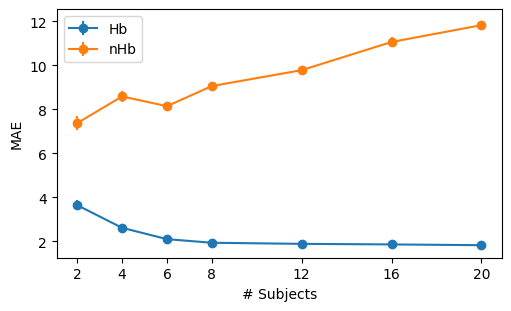

In [27]:
nrows, ncols = 1, 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True)
ax = axes[0, 0]

me, sem, std = _process(hbm_error[..., 0].reshape(N_LIM, -1))
ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Hb")

me, sem, std = _process(nhbm_error[..., 0].reshape(N_LIM, -1))
ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="nHb")

ax.legend()
ax.set_xticks(N_space[:N_LIM])
ax.set_ylabel("MAE")
ax.set_xlabel("# Subjects");

In [26]:
hbm_error[..., 0].shape

(7, 12, 50)

In [ ]:
nrows, ncols = 1, 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True)
ax = axes[0, 0]

me, sem, std = _process(hbm_error[..., 0].reshape(N_LIM, -1))
ax.errorbar(x=N_space[:N_LIM], y=me, yerr=std, marker="o", label="Hb")

me, sem, std = _process(nhbm_error[..., 0].reshape(N_LIM, -1))
ax.errorbar(x=N_space[:N_LIM], y=me, yerr=std, marker="o", label="nHb")

ax.legend()
ax.set_xticks(N_space[:N_LIM])
ax.set_ylabel("MAE")
ax.set_xlabel("# Subjects");

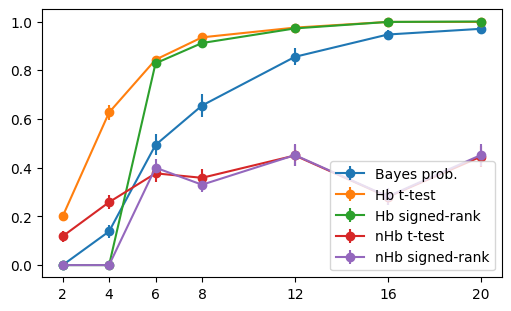

In [24]:
nrows, ncols = 1, 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True)
ax = axes[0, 0]

me, sem, std = _process_bp(hbm_mu_delta)
ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Bayes prob.")

me, sem, std = _process_fp(hbm_p_value[..., 0])
ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Hb t-test")

me, sem, std = _process_fp(hbm_p_value[..., 1])
ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Hb signed-rank")

me, sem, std = _process_fp(nhbm_p_value[..., 0])
ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="nHb t-test")

me, sem, std = _process_fp(nhbm_p_value[..., 1])
ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="nHb signed-rank")

ax.legend()
ax.set_xticks(N_space[:N_LIM])

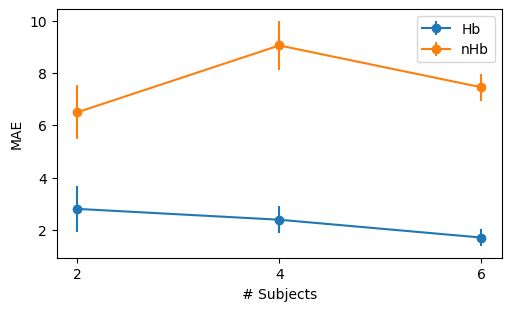

In [34]:
nrows, ncols = 1, 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True)
ax = axes[0, 0]

me, sem, std = _process(hbm_error[..., 0].reshape(N_LIM, -1))
ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Hb")

me, sem, std = _process(nhbm_error[..., 0].reshape(N_LIM, -1))
ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="nHb")

ax.legend()
ax.set_xticks(N_space[:N_LIM])
ax.set_ylabel("MAE")
ax.set_xlabel("# Subjects");


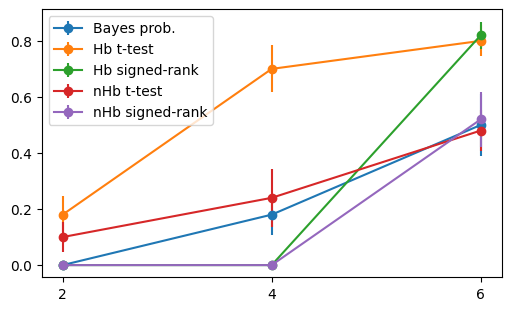

In [51]:
nrows, ncols = 1, 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True)
ax = axes[0, 0]

me, sem, std = _process_bp(hbm_mu_delta)
ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Bayes prob.")

me, sem, std = _process_fp(hbm_p_value[..., 0])
ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Hb t-test")

me, sem, std = _process_fp(hbm_p_value[..., 1])
ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Hb signed-rank")

me, sem, std = _process_fp(nhbm_p_value[..., 0])
ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="nHb t-test")

me, sem, std = _process_fp(nhbm_p_value[..., 1])
ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="nHb signed-rank")

ax.legend()
ax.set_xticks(N_space[:N_LIM])